code to predict pv generation

In [28]:
import numpy as np
import pandas as pd
from scipy.stats import norm, gamma
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.ticker import MaxNLocator # To ensure demand axis are integer.


# Third party packages.
import os                       # Execute tasks related to your operating system.

# import polars as pl             # Data handling ('Blazingly fast DataFrames') and is a drop-in replacement for pandas.
import pickle                   # Save and load data to and from pickle files.
import time
import json
import os
import joblib
from pathlib import Path
import logging
import json
import sqlite3

# from icecream import ic         # Print variables.
from datetime import datetime


Data Understanding

Load data set. Split with 80% and 20% split

In [29]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger('To fetch data from database and save as csv')

CONFIG_PATH = "/Users/sgawde/work/eaisi-code/main-branch-11-may/ENEXIS/workspaces/sandeep/config/config.json"

# === CONFIG ===

with open(CONFIG_PATH, "r") as f:
    config = json.load(f)

MODEL_RUN_RESULTS_DIR = config['ned']['ned_model_download_dir']

# Connect to the SQLite database
db_path = '/Users/sgawde/work/eaisi-code/main-branch-11-may/ENEXIS/src/data/WARP.db'
conn = sqlite3.connect(db_path)
# Connect to the SQLite database using the existing db_path
conn = sqlite3.connect(db_path)
# Step 2: Read data from table
df_pd_orig = pd.read_sql_query("SELECT * FROM master_warp ORDER BY target_datetime DESC", conn)

# Step 3: Close the connection
conn.close()

logger = logging.getLogger('Database fetch complete')


To draw line graph

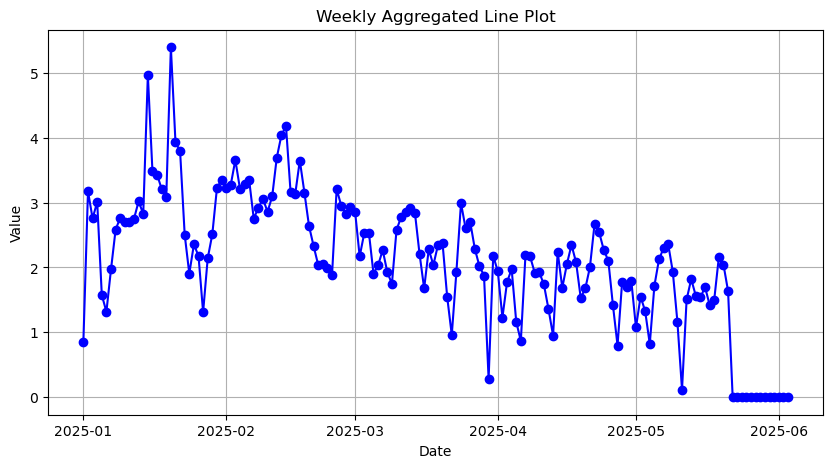

In [30]:
# Convert hr column to datetime (if not already)
df_pd_orig['target_datetime'] = pd.to_datetime(df_pd_orig['target_datetime'])

# Resample by day and aggregate (e.g., taking the sum or mean)
df_daily = df_pd_orig.resample('D', on='target_datetime').sum()  # You can use .mean(), .max(), etc.
# Extract only the day part
# print(df_daily.head(3))
df_daily['day'] = df_pd_orig['target_datetime'].dt.day

plt.figure(figsize=(10, 5))
plt.plot(df_daily.index, df_daily['Price'], marker='o', linestyle='-', label='Price', color='b')


# Labels and Title
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Weekly Aggregated Line Plot")
plt.grid()

plt.show()


Descriptive Statistics

In [31]:
# Using Pandas.
df_pd_num = df_pd_orig.select_dtypes(include='number')

# Column names (Pandas: df_pd_orig_num.columns.tolist()).
l_df_num_names = df_pd_num.columns
print(f"We have {len(l_df_num_names)} numerical variables:\n{l_df_num_names}")

# Convert to datetime format
df_pd_orig_str = df_pd_orig.select_dtypes(include='object')
print("Number of rows:", df_pd_orig_str.shape[0], "and column names are:", df_pd_orig_str.columns, "and column types are:", df_pd_orig_str.dtypes)

We have 34 numerical variables:
Index(['hour', 'day_of_week', 'month', 'day_of_year', 'hour_sin', 'hour_cos',
       'weekday_sin', 'weekday_cos', 'yearday_sin', 'yearday_cos', 'is_dst',
       'is_holiday', 'is_weekend', 'is_non_working_day', 'Load', 'Price',
       'Flow_BE', 'Flow_DE', 'Flow_GB', 'Flow_DK', 'Flow_NO', 'Total_Flow',
       'temperature_2m', 'wind_speed_10m', 'apparent_temperature',
       'cloud_cover', 'snowfall', 'diffuse_radiation',
       'direct_normal_irradiance', 'shortwave_radiation', 'Wind_Vol',
       'WindOffshore_Vol', 'Solar_Vol', 'Nuclear_Vol'],
      dtype='object')
Number of rows: 3696 and column names are: Index(['local_datetime'], dtype='object') and column types are: local_datetime    object
dtype: object


To check if the output column has unique values

In [32]:
l_col = ['Price']

for s_col in l_col:
    print(f"{l_col}: {df_pd_orig[l_col]}")
    print(f"{s_col}: {df_pd_orig[s_col].unique()}")

['Price']:         Price
0     0.00000
1     0.00000
2     0.00000
3     0.00000
4     0.00000
...       ...
3691  0.00068
3692  0.00328
3693  0.00416
3694  0.00624
3695  0.01362

[3696 rows x 1 columns]
Price: [0.      0.1149  0.12227 ... 0.00328 0.00416 0.00624]


Contruct a descriptive summary

In [33]:
df_pd_orig.describe()

,hour,day_of_week,month,day_of_year,hour_sin,hour_cos,weekday_sin,weekday_cos,yearday_sin,yearday_cos,...,apparent_temperature,cloud_cover,snowfall,diffuse_radiation,direct_normal_irradiance,shortwave_radiation,Wind_Vol,WindOffshore_Vol,Solar_Vol,Nuclear_Vol
count,3696.000000,3696.000000,3696.000000,3696.000000,3.696000e+03,3.696000e+03,3.696000e+03,3.696000e+03,3696.000000,3696.000000,...,3696.000000,3696.000000,3696.0,3696.000000,3696.000000,3696.000000,3.696000e+03,3.696000e+03,3.696000e+03,3696.000000
mean,11.500000,3.000000,3.071429,77.500000,-2.018587e-17,-5.454992e-17,-1.730218e-17,-3.844928e-18,0.711623,0.172343,...,4.226229,53.448593,0.0,42.559519,133.220959,108.236201,1.469261e+06,1.438713e+06,2.899107e+06,316941.626082
std,6.923123,2.000271,1.468952,44.461049,7.072025e-01,7.072025e-01,7.072025e-01,7.072025e-01,0.270107,0.625347,...,6.414206,46.785765,0.0,65.238607,242.073146,199.292159,1.707850e+06,1.368661e+06,5.161975e+06,230290.108908
min,0.000000,0.000000,1.000000,1.000000,-1.000000e+00,-1.000000e+00,-9.749279e-01,-9.009689e-01,0.017202,-0.881192,...,-8.752669,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,5.750000,1.000000,2.000000,39.000000,-7.071068e-01,-7.071068e-01,-7.818315e-01,-9.009689e-01,0.546711,-0.412034,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.072790e+05,1.748865e+05,0.000000e+00,0.000000
50%,11.500000,3.000000,3.000000,77.500000,6.123234e-17,-6.123234e-17,0.000000e+00,-2.225209e-01,0.788580,0.235370,...,2.793640,74.500000,0.0,0.000000,0.000000,0.000000,7.547045e+05,1.020373e+06,0.000000e+00,484750.000000
75%,17.250000,5.000000,4.000000,116.000000,7.071068e-01,7.071068e-01,7.818315e-01,6.234898e-01,0.945320,0.783266,...,8.430159,100.000000,0.0,83.321707,133.695778,120.000000,2.283020e+06,2.471040e+06,3.472424e+06,487000.000000
max,23.000000,6.000000,6.000000,154.000000,1.000000e+00,1.000000e+00,9.749279e-01,1.000000e+00,0.999986,0.999852,...,26.950579,100.000000,0.0,307.118225,818.356445,875.000000,6.551295e+06,4.158000e+06,2.271706e+07,490500.000000


To plot corelation matrix

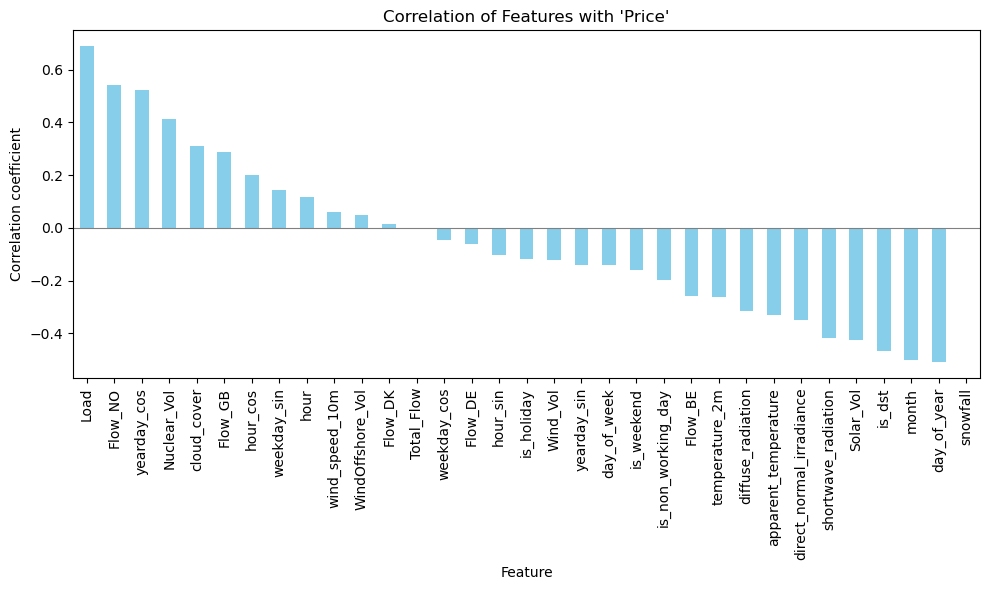

,Feature,Correlation with Price
0,hour,0.118012
1,day_of_week,-0.139471
2,month,-0.501669
3,day_of_year,-0.510052
4,hour_sin,-0.104883
5,hour_cos,0.199148
6,weekday_sin,0.143825
7,weekday_cos,-0.046473
8,yearday_sin,-0.139434
9,yearday_cos,0.523261


Columns removed due to low correlation with 'Price' (between -0.25 and 0.25):
['hour', 'day_of_week', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'yearday_sin', 'is_holiday', 'is_weekend', 'is_non_working_day', 'Flow_DE', 'Flow_DK', 'Total_Flow', 'wind_speed_10m', 'Wind_Vol', 'WindOffshore_Vol']

Updated DataFrame shape (only 'Price' and highly correlated features):
(3696, 18)


In [34]:
# Compute correlation of 'Price' with all other numeric columns
price_corr = df_pd_num.corr()['Price'].drop('Price')

# Plot bar chart of correlations with 'Price'
plt.figure(figsize=(10, 6))
price_corr.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Correlation of Features with 'Price'")
plt.ylabel('Correlation coefficient')
plt.xlabel('Feature')
plt.axhline(0, color='gray', linewidth=0.8)
plt.tight_layout()
plt.show()

# Display correlation values as a table
corr_table = price_corr.reset_index()
corr_table.columns = ['Feature', 'Correlation with Price']
display(corr_table)

# Identify columns with low correlation to 'Price' (between -0.25 and 0.25)
columns_to_remove = price_corr[(price_corr >= -0.25) & (price_corr <= 0.25)].index.tolist()
print("Columns removed due to low correlation with 'Price' (between -0.25 and 0.25):")
print(columns_to_remove)

# Filter DataFrame to keep only 'Price' and highly correlated features
selected_features = ['Price'] + [col for col in price_corr.index if col not in columns_to_remove]
df_filtered_price = df_pd_num[selected_features]
print("\nUpdated DataFrame shape (only 'Price' and highly correlated features):")
print(df_filtered_price.shape)
